# Preprocessing the public Event Log

## Reading Raw Event data in XES format as an Event Log ##

In [ ]:
import pandas as pd
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as xes_converter

hospital_log_all = xes_importer.apply('Data\Hospital_log_all.xes')

print("Number of traces present in the full event log:", len(hospital_log_all))

num_of_events = 0
for trace in hospital_log_all:
    num_of_events = num_of_events + len(trace)

print("Number of events in full event log:", num_of_events)

### Utility code to automatically load newly compiled classes into Jupiter notebook

In [ ]:
from IPython import get_ipython
ip = get_ipython()
ip.magic("reload_ext autoreload")
ip.magic("autoreload 2")

In [1]:
%reload_ext autoreload
# Configure autoreload to automatically reload all modules
%autoreload 2

## Getting a subset of the full event log based on traces ##

We consider 33.3% of the traces in the full event log. This is for the ease of computation later.

In [ ]:
from Preprocessing import DivideDatasets

hospital_log_initial = DivideDatasets.get_subset(hospital_log_all, 3)

print("Number of traces present in the event log subset:", len(hospital_log_initial))

num_of_events = 0
for trace in hospital_log_initial:
     num_of_events = num_of_events + len(trace)

print("Number of events in the event log subset:", num_of_events)

pm4py.write_xes(hospital_log_initial, "Data\Processed\Hospital_Log_Initial.xes")

### ``When starting from middle with divided

In [ ]:
import pandas as pd
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as xes_converter

hospital_log_initial = xes_importer.apply('Data\Processed\Hospital_Log_Initial.xes')

## Translating the event log content into English

Mainly the activity name is in English. For a better clarity while analysing, we convert that to English

In [ ]:
#hospital_log_initial_temp = hospital_log_initial

In [ ]:
from Preprocessing import TranslationManager

hospital_log_translated = TranslationManager.translate(hospital_log_initial, 'en')

pm4py.write_xes(hospital_log_translated, "Data\Processed\Hospital_Log_Translated.xes")

### ``When starting from middle (since Translation is costly)

In [ ]:
import pandas as pd
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as xes_converter

hospital_log_translated = xes_importer.apply('Data\Processed\Hospital_Log_Translated.xes')

In [ ]:
len(hospital_log_translated)

## Remove duplicates

The logic here we are using is:
  1. Extract traces & events into two lists from the original EventLog
  2. Create a Pandas dataframe using above two lists as columns & remove duplicates from there
  3. Rebuild the EventLog referring to original EventLog by only adding values persent in dataframe

In [ ]:
import pm4py.utils as pm4py_utils

# Define neww lists for trace and event data
all_traces = []
all_events = []

# Get trace and event data from the event log object

###
###
#translation seems giving low hits
#for trace in hospital_log_translated:
###
###

for trace in hospital_log_initial:
    # Get trace name for each trace
    trace_name = trace.attributes['concept:name']

    # Make the event name as unique as possible
    for event in trace:
        all_traces.append(trace_name)
        # Extract event name
        event_name = event['concept:name'] + ' - ' + event['Producer code'] + str(event['Specialism code']) + ' - ' + str(event['time:timestamp'])
        if 'org:group' in event:
            event_name = event_name + ' - ' + event['org:group'] 
        if 'Section' in event:
            event_name = event_name + ' - ' + event['Section']
            
        all_events.append(event_name)

# Raise error if the liists length are different
if len(all_traces) != len(all_events):
    raise ValueError("Lengths of all_traces and all_events do not match.")

# Creat a Pandas DataFrame
hospital_log_initial_df = pd.DataFrame({'trace': all_traces, 'event': all_events})
#print("All Events:", len(hospital_log_translated_df))
# Remove duplicates
hospital_log_initial_df = hospital_log_initial_df.drop_duplicates(subset=['trace', 'event'])
#print("Dup removed removed:", len(hospital_log_translated_df))

hospital_log_dup_removed = pm4py_utils.EventLog()

# Initialize a dictionary to keep track of added events for each trace
events_included = {}

# Iterate over the original event log to reconstruct the dupliacate removed event log
for trace in hospital_log_initial:
    # Get trace name
    trace_name = trace.attributes['concept:name']
    
    # Check if trace_name already exists in the DataFrame
    if trace_name in hospital_log_initial_df['trace'].values:
        # Create a new trace object
        new_trace = pm4py_utils.Trace()
        hospital_log_dup_removed.append(new_trace)
        # Copy trace attributes
        for key, value in trace.attributes.items():
            new_trace.attributes[key] = value
        # Initialize a set to keep track of added events for the current trace
        events_included[trace_name] = set()
        # Associate the trace name with all events within the trace
        for event in trace:
            event_name = event['concept:name'] + ' - ' + event['Producer code'] + str(event['Specialism code']) + ' - ' + str(event['time:timestamp'])
            if 'org:group' in event:
                event_name = event_name + ' - ' + event['org:group']
            if 'Section' in event:
                event_name = event_name + ' - ' + event['Section']
            
            # Check if the event name is in the cleaned DataFrame and not already added
            if event_name in hospital_log_initial_df[hospital_log_initial_df['trace'] == trace_name]['event'].values \
                    and event_name not in events_included[trace_name]:
                # Create a new event object
                new_event = pm4py_utils.Event()
                # Copy event attributes
                for key, value in event.items():
                    new_event[key] = value
                # Add the event to the trace
                new_trace.append(new_event)
                # Add the event name to the set of added events for the current trace
                events_included[trace_name].add(event_name)

print("Number of traces present in the duplicate removed event log:", len(hospital_log_dup_removed))

num_of_events = 0
for trace in hospital_log_dup_removed:
     num_of_events = num_of_events + len(trace)

print("Number of events in the duplicate removed event:", num_of_events)

# write into file
pm4py.write_xes(hospital_log_dup_removed, "Data\Processed\Hospital_Log_Dup_Removed.xes")

### ``When starting from middle (dup removed)

In [11]:
import pandas as pd
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as xes_converter

hospital_log_dup_removed = xes_importer.apply('Data\Processed\Hospital_Log_Dup_Removed.xes')

parsing log, completed traces ::   0%|          | 0/381 [00:00<?, ?it/s]

## Remove traces with no events

In [ ]:
import xml.etree.ElementTree as ET

def count_traces_without_events(Logg):
    
    # Count traces without events
    count = 0
    all_traces=0
    for trace in Logg:
        # Check if trace has any events
        all_traces += 1
        present = 0
        for event in trace:
            present += 1
        if present==0:
            count += 1
        if all_traces >379:
            print(all_traces, ": ", present)

    return count, all_traces

traces_without_events, all_tracesss = count_traces_without_events(hospital_log_translated_emp)
print("Number of traces:", all_tracesss)
print("Number of traces without any events:", traces_without_events)


# Frequent Pattern Mining

## Finding most frequest patterns

### Using FP-Growth algorithm

We are using the fp growth algorithm here to find frequent flow variants.
In creating transactions to be fed into into FP Growth, we use concept:name as the key of each event
Also sending the transaction list in chunks to FP Growth algo to process to reduce the complexity in processing,
and later merging the results by removing duplicates, etc

In [ ]:
import pandas as pd
from collections import defaultdict
from FrequentPatternMining import FPGrowthHandler, TransactionManager


# GEt the list of transactions based on events in each trace
transactions_list = TransactionManager.create_transactions(hospital_log_dup_removed)

# Split transactions list into chunks 
# for the computational ease
chunk_size = 5
num_of_chunks = len(transactions_list) // chunk_size +(len(transactions_list) % chunk_size > 0)
frequent_variants_all = pd.DataFrame( columns=['support', 'itemsets'])

# Process chunks by looping
for i in range(num_of_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(transactions_list))
    transactions_chunk = transactions_list[start_idx:end_idx]
    
    # Mine frequent varints for the current chunk using FP-Growth algorithm
    print(f"Processing chunk {i+1} of {num_of_chunks}...")
    frequent_variants_chunk = FPGrowthHandler.mine_frequent_variants(transactions_chunk, min_support=0.1)
    
    # Merge frequent variants with previous chunks
    frequent_variants_all = pd.concat([frequent_variants_all, frequent_itemsets_chunk])
    print("Mining finshed for chunk {i+1} of {num_of_chunks}...")

# Remove duplicates and sort the combined frequent variants
frequent_variants_all = frequent_variants_all.groupby('itemsets').agg({'support': 'sum'}).reset_index()
frequent_variants_all = frequent_variants_all.sort_values(by='support', ascending=False)

print("Full Frequent Variants List: ")
frequent_variants_all

### Using Apriori

In [ ]:
import pandas as pd
from collections import defaultdict
from FrequentPatternMining import AprioriHandler, TransactionManager


# GEt the list of transactions based on events in each trace
transactions_list = TransactionManager.create_transactions(hospital_log_dup_removed)

# Split transactions list into chunks 
# for the computational ease
chunk_size = 5
num_of_chunks = len(transactions_list) // chunk_size +(len(transactions_list) % chunk_size > 0)
frequent_variants_all = pd.DataFrame( columns=['support', 'itemsets'])

# Process chunks by looping
for i in range(num_of_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(transactions_list))
    transactions_chunk = transactions_list[start_idx:end_idx]
    
    # Mine frequent variantsa for the current chunk using Apriori algorithm
    print(f"Processing chunk {i+1} of {num_of_chunks}...")
    frequent_variants_chunk = AprioriHandler.mine_frequent_variants(transactions_chunk, min_support=0.1)
    
    # Merge frequent varints with previous chunks
    frequent_variants_all = pd.concat([frequent_variants_all, frequent_itemsets_chunk])
    print("Mining finshed for chunk {i+1} of {num_of_chunks}...")

# Remove duplicates and sort the combined frequent variants
frequent_variants_all = frequent_variants_all.groupby('itemsets').agg({'support': 'sum'}).reset_index()
frequent_variants_all = frequent_variants_all.sort_values(by='support', ascending=False)

print("Full Frequent Variants List: ")
frequent_variants_all

### Direct method (with no ML)

Since it was unable to find the final list of frequent flow variants using both the above FP-Growth & the Apriori algorithms,
now we go for a direct text mapping approach without any machine learning approach involved.

In [12]:
import pandas as pd
from collections import defaultdict
from FrequentPatternMining import DirectPatternMatchHandler


# Mine frequent variants using Direct text match
event_flows_with_counts_df = DirectPatternMatchHandler.mine_frequent_variants(hospital_log_dup_removed, sort_order="DESC")


print("Full Frequent Variants List: ")
event_flows_with_counts_df

Full Frequent Variants List: 


,Event Flow,Count
0,"(vervolgconsult poliklinisch, administratief t...",11
1,"(vervolgconsult poliklinisch, administratief t...",6
2,"(1e consult poliklinisch, administratief tarie...",4
3,"(vervolgconsult poliklinisch, administratief t...",3
4,"(vervolgconsult poliklinisch, administratief t...",3
...,...,...
342,"(e.c.g. - elektrocardiografie, coupe ter ...",1
343,"(echografie - genitalia interna, thorax, 1e c...",1
344,"(aanname laboratoriumonderzoek, ca-125 mbv mei...",1
345,"(aanname laboratoriumonderzoek, aanname labora...",1


In [13]:
event_flows_with_counts_df.to_csv("Data\\Processed\\EventFlowsWithCounts.csv", index=False)

### ``When starting from middle (flow variants with counts)

In [9]:
import pandas as pd

event_flows_with_counts_df = pd.read_csv("Data\\Processed\\EventFlowsWithCounts.csv")

# Clustering

Here we focus to perform Agglomerative Heirachical clustering with average linkage method.

## Set weights for each event flow variant based on its frequency 

In [14]:
from Clustering import ClusterUtil

# Assign weights for each variant
event_flows_with_counts_df = ClusterUtil.assign_weights(event_flows_with_counts_df)

event_flows_with_counts_df

,Event Flow,Count,Weight
0,"(vervolgconsult poliklinisch, administratief t...",11,0.028871
1,"(vervolgconsult poliklinisch, administratief t...",6,0.015748
2,"(1e consult poliklinisch, administratief tarie...",4,0.010499
3,"(vervolgconsult poliklinisch, administratief t...",3,0.007874
4,"(vervolgconsult poliklinisch, administratief t...",3,0.007874
...,...,...,...
342,"(e.c.g. - elektrocardiografie, coupe ter ...",1,0.002625
343,"(echografie - genitalia interna, thorax, 1e c...",1,0.002625
344,"(aanname laboratoriumonderzoek, ca-125 mbv mei...",1,0.002625
345,"(aanname laboratoriumonderzoek, aanname labora...",1,0.002625


In [15]:
event_flows_with_counts_df.to_csv('Data\\Processed\\FlowVariantsWithWeights.csv', index=False)


## Calculate distances among flow variant pairs

Here we use Jaccard Similaritiy method for this purpose

In [16]:
from Clustering import ClusterUtil

# Assign a unque variant id for each flow 
# focusing plotting later to avoid huge texts
event_flows_with_counts_df = ClusterUtil.assign_unique_variant_ids(event_flows_with_counts_df, col_name='Variant No')

In [17]:
event_flows_with_counts_df

,Event Flow,Count,Weight,Variant No
0,"(vervolgconsult poliklinisch, administratief t...",11,0.028871,Variant1
1,"(vervolgconsult poliklinisch, administratief t...",6,0.015748,Variant2
2,"(1e consult poliklinisch, administratief tarie...",4,0.010499,Variant3
3,"(vervolgconsult poliklinisch, administratief t...",3,0.007874,Variant4
4,"(vervolgconsult poliklinisch, administratief t...",3,0.007874,Variant5
...,...,...,...,...
342,"(e.c.g. - elektrocardiografie, coupe ter ...",1,0.002625,Variant343
343,"(echografie - genitalia interna, thorax, 1e c...",1,0.002625,Variant344
344,"(aanname laboratoriumonderzoek, ca-125 mbv mei...",1,0.002625,Variant345
345,"(aanname laboratoriumonderzoek, aanname labora...",1,0.002625,Variant346


In [18]:
event_flows_with_counts_df.to_csv('Data\\Processed\\FlowVariantsWithWeightsAndVariantNo.csv', index=False)

In [19]:
from Clustering import ClusterHandler

# Calculate Jaccard similarity for flows
pairwise_distance_list = ClusterHandler.calculate_distances_with_jaccard(event_flows_with_counts_df)

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [20]:
with open('Data\\Processed\\FlowParewiseDistancesWithJaccard.txt', 'w') as file:
    for element in pairwise_distance_list:
        file.write(f"{element}\n")

## Perform Agglomerative Clustering

Here we use the average linkage method which considers distance among all other nodes.

In [21]:
from Clustering import ClusterHandler

# Perform Agglomerative Hierarchical clustering with Average Linkage method
clustered_flows = ClusterHandler.perform_hierarchical_clustering(pairwise_distance_list, method='average')

d:\EDU\1MSc\Semester3\Research\Implementation\Repository\process-mining-with-clustering\FrequentFlowVariantsWithHierarchicalClustering\Main\Clustering\ClusterHandler.py:43: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clustered_flows = linkage(pairwise_distance_list, method=method)


In [22]:
clustered_flows

array([[  0.        ,   1.        ,   0.        ,   2.        ],
       [  3.        , 347.        ,   0.        ,   3.        ],
       [  2.        , 216.        ,   0.        ,   2.        ],
       ...,
       [681.        , 684.        ,   3.58765955, 241.        ],
       [688.        , 689.        ,   3.6962824 , 106.        ],
       [690.        , 691.        ,   7.23968784, 347.        ]])

## Generate dendogram for the heirachical tree

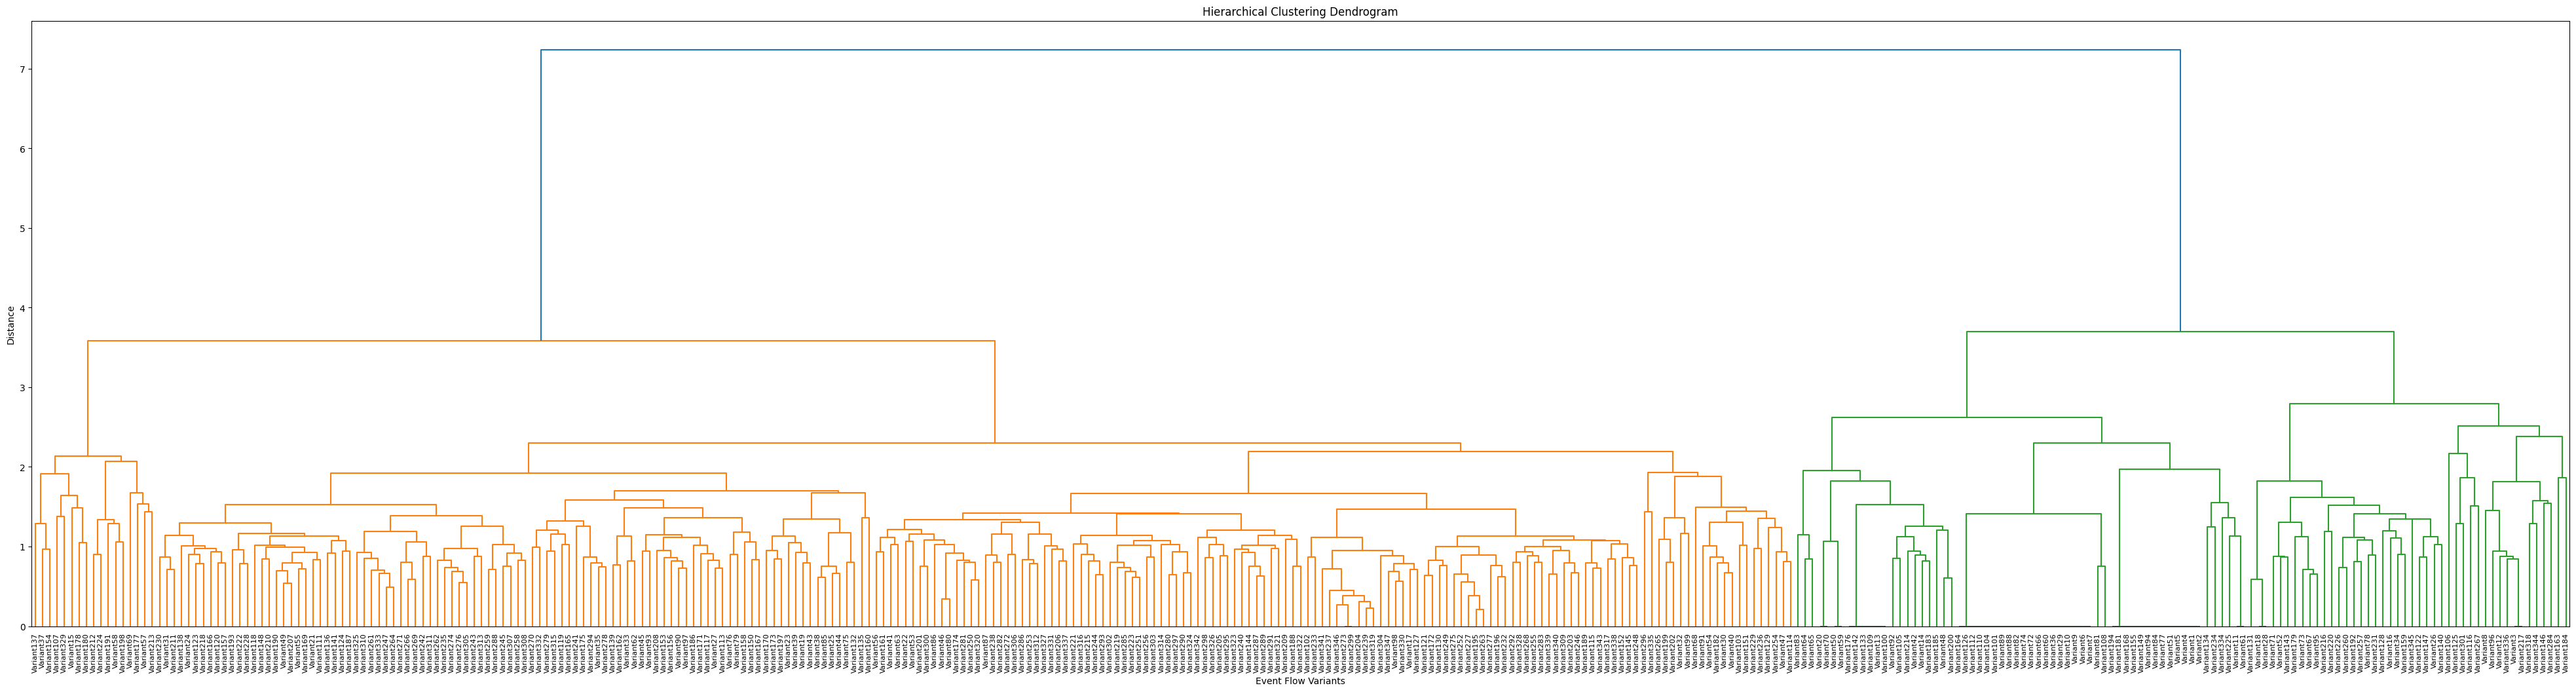

In [26]:
from Clustering import ClusterHandler

# plot & save the dendogram
ClusterHandler.generate_dendogram(clustered_flows, event_flows_with_counts_df,
                                        title='Hierarchical Clustering Dendrogram',
                                        col_name='Variant No',
                                        xlabel= 'Event Flow Variants', 
                                        ylabel= 'Distance', 
                                        save_figure_to= 'Visualize\\HierarchicalClusteringDendrogram.png')
